In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('Data collected - combine.csv')
df

,date,boeing,DJI,dollar,oil,GDP,CPI,delivery,Al
0,2000/1/1,28.60289,11522.56,100.800003,27.224286,10002.17900,0.297089,33.000000,NaN
1,2000/1/8,28.40117,11722.98,101.720001,27.114648,10021.06677,0.278729,34.846154,NaN
2,2000/1/15,29.49043,11251.71,101.760002,27.005011,10039.95454,0.260369,36.692308,NaN
3,2000/1/22,28.80461,10738.87,104.480003,26.895374,10058.84231,0.242009,38.538462,NaN
4,2000/1/29,28.40117,10963.80,104.290001,26.785736,10077.73008,0.223649,40.384615,NaN
...,...,...,...,...,...,...,...,...,...
1309,2025/2/1,181.49000,44303.40,108.040001,71.541500,27967.69700,0.190752,44.000000,2582.189
1310,2025/2/8,180.55000,44546.08,106.570000,71.541500,27967.69700,0.190752,44.000000,2582.189
1311,2025/2/15,NaN,43428.02,NaN,NaN,NaN,NaN,NaN,2582.189
1312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2582.189


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np

In [6]:
df = df.drop(columns = ['date'])
df = df.dropna()

In [7]:
X = df.drop(columns=["boeing"])
y = df["boeing"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [47,48,49,50],
    'max_depth': [None, 5, 10,13,14,15],
    'min_samples_split': [2,4, 5, 6,8,10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                           cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


y_best_pred = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_best_pred)
r2_best = r2_score(y_test, y_best_pred)


feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

best_params, mse_best, r2_best, feature_importance


({'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 50},
 43.46319840905752,
 0.994987885597414,
 DJI         0.517518
 GDP         0.385457
 CPI         0.065353
 oil         0.010053
 dollar      0.007811
 delivery    0.006930
 Al          0.006878
 dtype: float64)

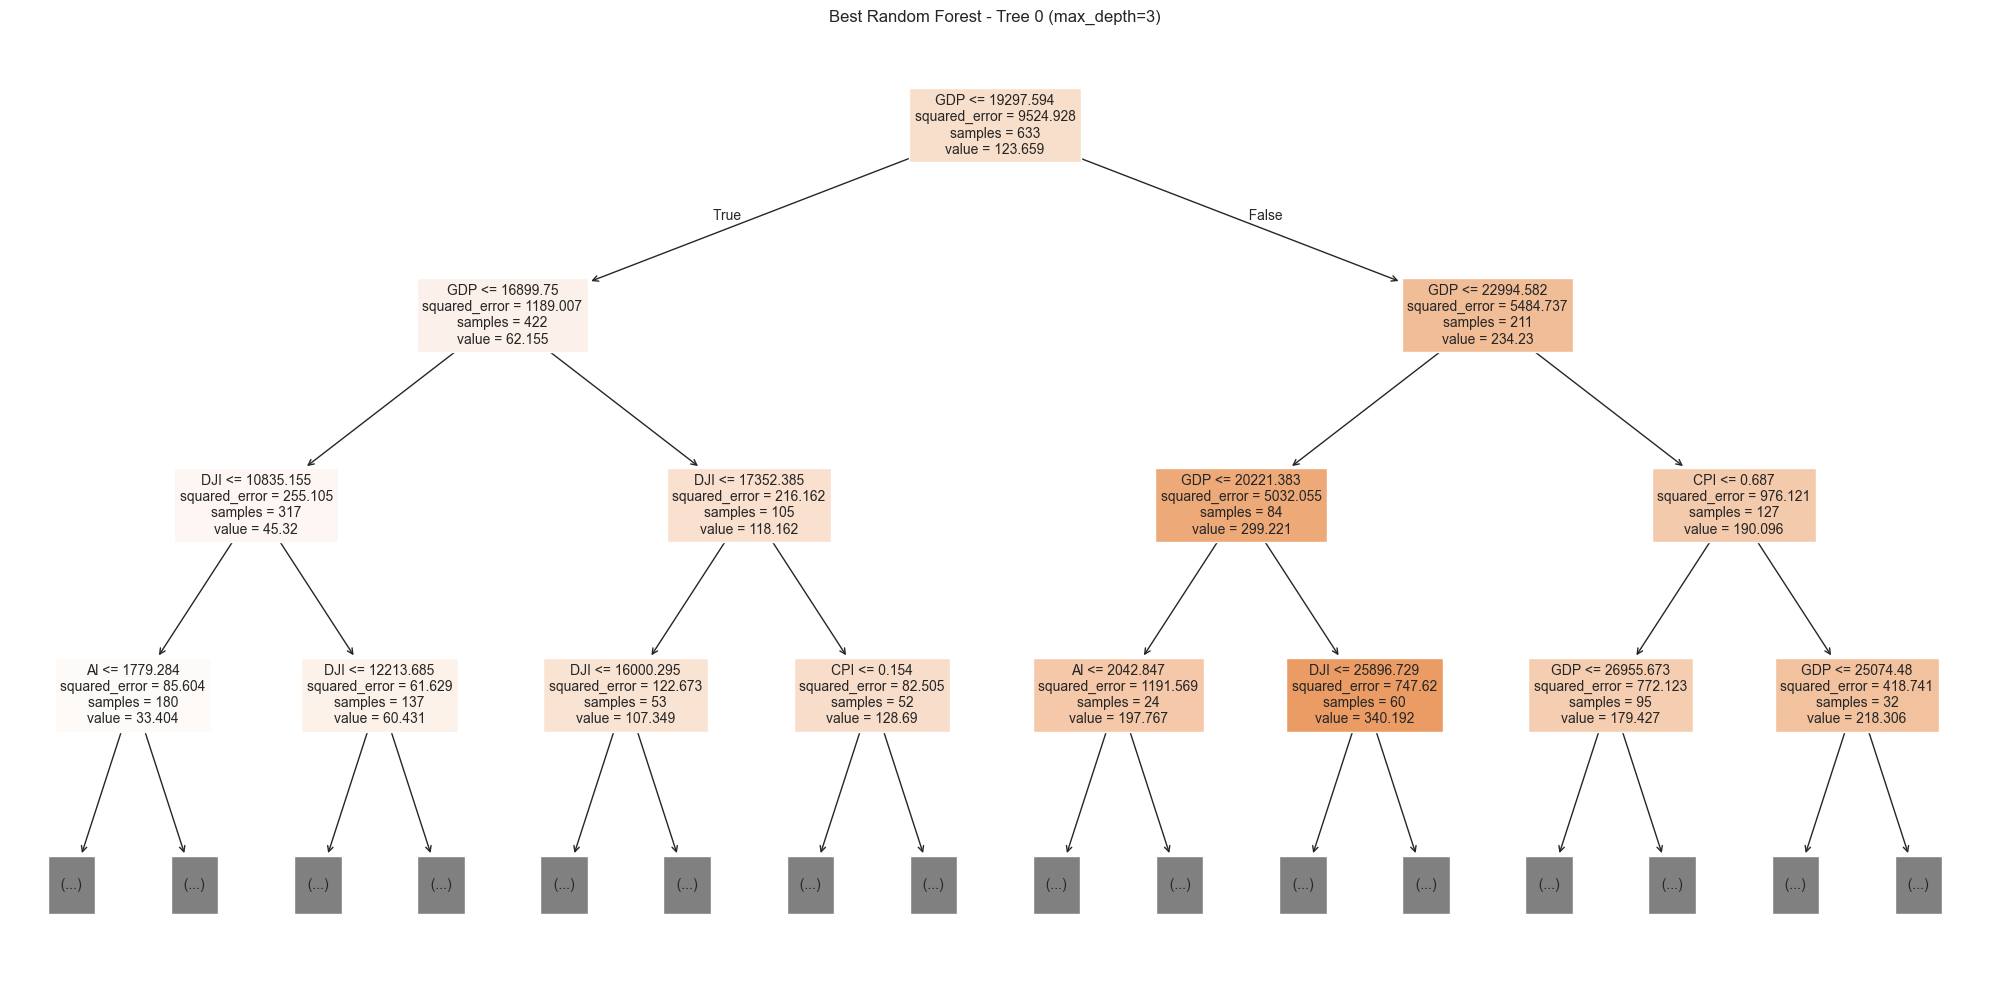

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
plot_tree(best_model.estimators_[0], 
          feature_names=X.columns, 
          filled=True, 
          max_depth=3,       # 可调节深度
          fontsize=10)
plt.title("Best Random Forest - Tree 0 (max_depth=3)")
plt.tight_layout()
plt.show()


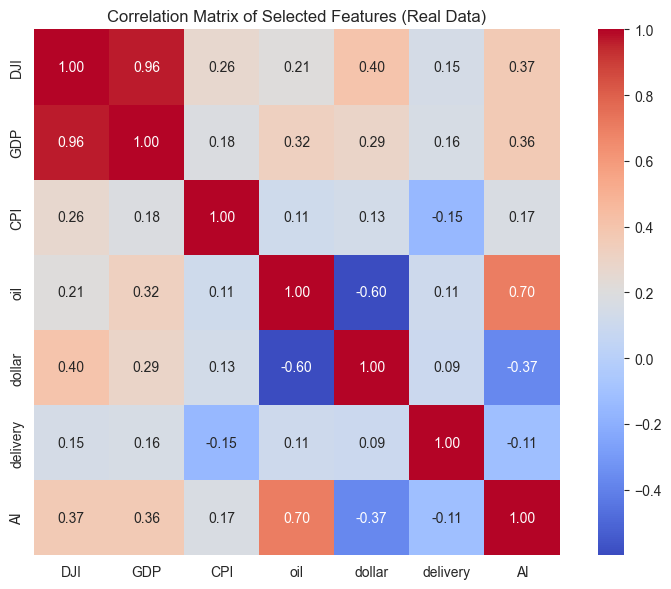

In [11]:
import seaborn as sns


selected_columns = ['DJI', 'GDP', 'CPI', 'oil', 'dollar', 'delivery', 'Al']
selected_data = df[selected_columns]

# 计算相关系数矩阵
corr_matrix_real = selected_data.corr()

# 可视化真实数据的相关性矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_real, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Selected Features (Real Data)")
plt.tight_layout()
plt.show()


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),       # degree 可调
    ('model', LinearRegression())         # 可换成 Ridge、Lasso
])


param_grid = {
    'poly__degree': [1, 2, 3, 4],  # 多项式阶数
}


grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)


print("Best parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)


y_pred = grid.predict(X_test)
mse_poly = mean_squared_error(y_test, y_pred)
r2_poly = r2_score(y_test, y_pred)
print(r2_poly)
print(mse_poly)



Best parameters: {'poly__degree': 3}
Best CV R²: 0.9924068542496169
0.9921408397658658
68.15172463112742


In [17]:

best_model = grid.best_estimator_


poly_transformer = best_model.named_steps['poly']


linear_model = best_model.named_steps['model']


import pandas as pd


feature_names = X_train.columns  # 如果 X_train 是 DataFrame，否则手动写成列表


poly_feature_names = poly_transformer.get_feature_names_out(feature_names)


coefficients = linear_model.coef_.flatten()


coef_df = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)


print(coef_df.head(15))


              Feature  Coefficient
11            DJI GDP   360.527857
54          DJI GDP^2  -329.238323
39          DJI^2 GDP   258.386359
50        DJI oil GDP   230.918077
26              GDP^2  -195.094095
57         DJI GDP Al  -191.289293
102    GDP^2 delivery  -169.510301
56   DJI GDP delivery   162.575439
4                 GDP   162.192088
55        DJI GDP CPI   155.579411
101         GDP^2 CPI  -154.480174
38          DJI^2 oil  -143.685240
8               DJI^2   -99.644303
100             GDP^3    96.483211
45     DJI dollar GDP   -91.909726


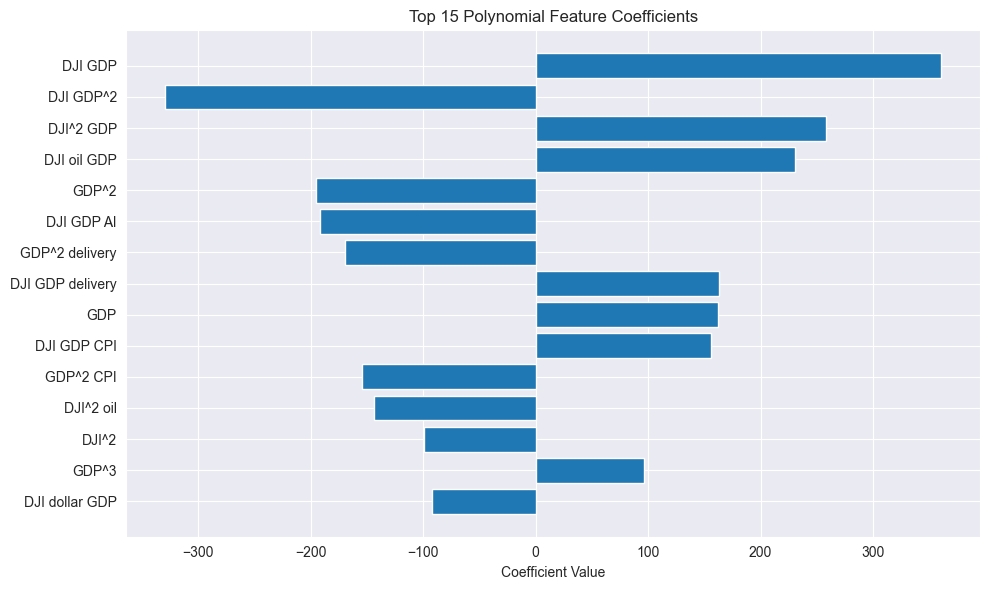

In [18]:
import matplotlib.pyplot as plt


feature_names = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']


best_model = grid.best_estimator_
poly = best_model.named_steps['poly']
linear = best_model.named_steps['model']


poly_feature_names = poly.get_feature_names_out(feature_names)
coefficients = linear.coef_.flatten()


coef_df = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)


top_k = 15
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:top_k][::-1], coef_df['Coefficient'][:top_k][::-1])
plt.title("Top 15 Polynomial Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.grid(True)
plt.show()
